In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data()

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


True

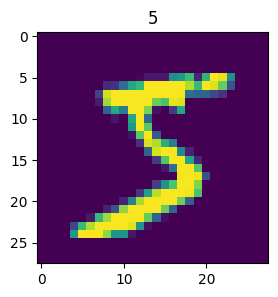

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [11]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [12]:
# 3 fully connected layers
class Network1(nn.Module):
  def __init__(self):
    super(Network1, self).__init__()
    self.fc1 = nn.Linear(784, 200)
    self.fc2 = nn.Linear(200, 100)
    self.fc3 = nn.Linear(100, 10)
    
  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = nn.functional.sigmoid(x)
    x = self.fc2(x)
    x = nn.functional.sigmoid(x)
    x = self.fc3(x)
    x = nn.functional.sigmoid(x)
    return x

In [13]:
eta = 0.3
epochs = 10

net1 = Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 10.600000381469727
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 18.420000076293945
 evaluation accuracy: 10.239999771118164
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 training accuracy: 12.449999809265137
epoch 1
 evaluation accuracy: 14.34000015258789
 evaluation accuracy: 39.79999923706055
 evaluation accuracy: 35.5
 evaluation accuracy: 39.400001525878906
 evaluation accuracy: 52.31999969482422
 evaluation accuracy: 59.41999816894531
 training accuracy: 43.7400016784668
epoch 2
 evaluation accuracy: 60.119998931884766
 evaluation accuracy: 58.2599983215332
 evaluation accuracy: 61.119998931884766
 evaluation accuracy: 57.599998474121094
 evaluation accuracy: 57.2400016784668
 evaluation accuracy: 58.319

ValueError: x and y must have same first dimension, but have shapes (100,) and (60,)

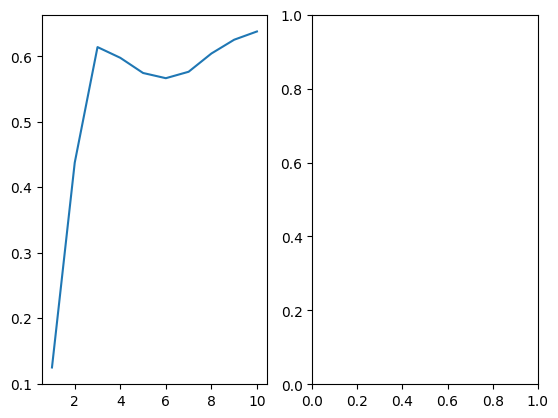

In [15]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/10 for i in range(10 * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.6, 0.9)
ax[0].set_title('net1 accuracy')

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/10 for i in range(10 * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_acc[0]} v eval {final_acc[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Terrible results, even if its only 10 epochs.

## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [16]:
# 3 fully connected layers with ReLU
class Network2(nn.Module):
  def __init__(self):
    super(Network2, self).__init__()
    self.fc1 = nn.Linear(784, 200)
    self.fc2 = nn.Linear(200, 100)
    self.fc3 = nn.Linear(100, 10)
    
  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    x = nn.functional.relu(x)
    x = self.fc3(x)
    x = nn.functional.softmax(x, dim=1)
    return x

In [18]:
eta = 0.3
epochs = 10

net2 = Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net2.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 9.119999885559082
 evaluation accuracy: 47.58000183105469
 evaluation accuracy: 57.79999923706055
 evaluation accuracy: 75.76000213623047
 evaluation accuracy: 78.83999633789062
 evaluation accuracy: 80.86000061035156
 training accuracy: 65.62666320800781
epoch 1
 evaluation accuracy: 80.5
 evaluation accuracy: 82.4000015258789
 evaluation accuracy: 82.72000122070312
 evaluation accuracy: 82.16000366210938
 evaluation accuracy: 82.0199966430664
 evaluation accuracy: 83.0199966430664
 training accuracy: 84.125
epoch 2
 evaluation accuracy: 82.95999908447266
 evaluation accuracy: 83.95999908447266
 evaluation accuracy: 83.26000213623047
 evaluation accuracy: 84.05999755859375
 evaluation accuracy: 84.0199966430664
 evaluation accuracy: 84.36000061035156
 training a

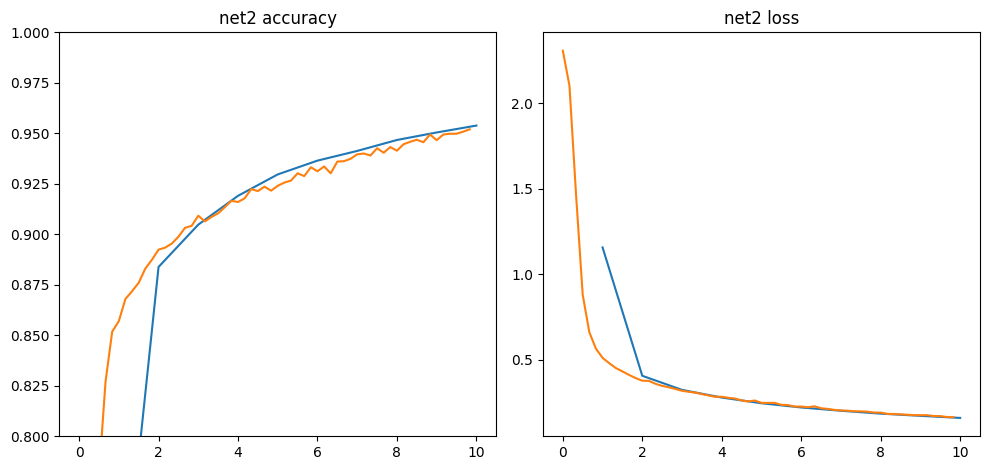

final loss: train (tensor(57230), 60000) v eval (tensor(4760), 5000)
final acc: train 0.9538333415985107 v eval 0.9520000219345093


In [22]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.8, 1.0)
ax[0].set_title('net2 accuracy')

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_acc[0]} v eval {final_acc[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

In [19]:
# 1 convlutional layer
# 2 fully connected layer
class Network3(nn.Module):
  def __init__(self, dropout_rate=0.2):
    super(Network3, self).__init__()
    self.conv = nn.Conv2d(1, 20, 5) # convolutional layer
    self.fc1 = nn.Linear(20 * 12 * 12, 100) # fully connected layer 1
    self.fc2 = nn.Linear(100, 10) # fully connected layer 2
    self.dropout = nn.Dropout(p=dropout_rate)
    
  def forward(self, x):
    x = self.conv(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    x = nn.functional.log_softmax(x, dim=1)
    return x

In [20]:
eta = 0.01
epochs = 16
l2_lambda = 0.01
dropout_rate = 0.2

net3 = Network3()
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0
 evaluation accuracy: 9.119999885559082
 evaluation accuracy: 51.52000045776367
 evaluation accuracy: 70.80000305175781
 evaluation accuracy: 78.08000183105469
 evaluation accuracy: 82.72000122070312
 evaluation accuracy: 85.18000030517578
 training accuracy: 69.58000183105469
epoch 1
 evaluation accuracy: 85.69999694824219
 evaluation accuracy: 86.80000305175781
 evaluation accuracy: 87.18000030517578
 evaluation accuracy: 87.5999984741211
 evaluation accuracy: 88.30000305175781
 evaluation accuracy: 88.73999786376953
 training accuracy: 88.38333129882812
epoch 2
 evaluation accuracy: 89.23999786376953
 evaluation accuracy: 89.33999633789062
 evaluation accuracy: 89.54000091552734
 evaluation accuracy: 89.87999725341797
 evaluation accuracy: 9

10


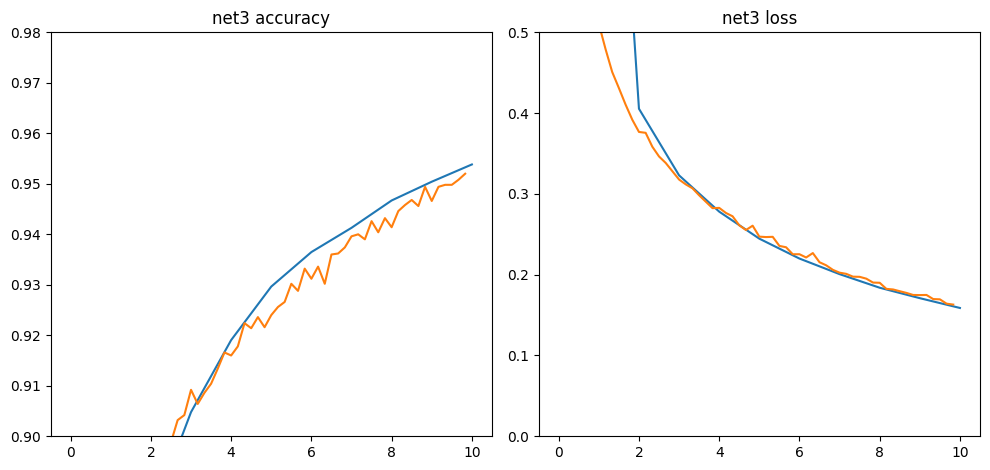

final loss: train (tensor(57230), 60000) v eval (tensor(4760), 5000)
final acc: train 0.9538333415985107 v eval 0.9520000219345093


In [23]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

print(len(train_accs))
ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, .98)
ax[0].set_title('net3 accuracy')

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_ylim(0.0, 0.5)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_acc[0]} v eval {final_acc[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Avoid overfitting with regularization techniques.